In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
!pip install torchinfo
from torchinfo import summary
!pip install einops
from einops.layers.torch import Rearrange

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.1 MB/s eta 0:00:00


## Prepare image


In [ ]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5)),
])
batch_size = 250

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=3)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Build model

In [ ]:
class PostionEmbedding(nn.Module):
    def __init__(self, B, H, W, patch_size, dim):
        super().__init__()
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim)).repeat(B, 1, 1).to(device)
        self.pos_embedding = nn.Parameter(torch.randn(1, (H//patch_size) * (W//patch_size) + 1, dim)).to(device)

    def forward(self, x):
        x = torch.cat([self.cls_token, x], dim=1)
        return x + self.pos_embedding

class PatchEmbedding(nn.Module):
    def __init__(self, in_chanel=3, patch_size=4, dim=512):
        super().__init__()
        self.patching = Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size)
        self.linear_embedding = nn.Linear(in_chanel * patch_size * patch_size, dim)

    def forward(self, x):

        x = self.patching(x)
        x = self.linear_embedding(x)
        # flatten
        return x

class Attention(nn.Module):
    def __init__(self, dim=512, n_head=4, dropout=0.1):
        super().__init__()

        self.attention = torch.nn.MultiheadAttention(embed_dim=dim,
                                                     num_heads=n_head,
                                                     dropout=dropout)

    def forward(self, x):

        attn_output, attn_output_weights = self.attention(x, x, x)
        return attn_output

In [ ]:

class MyViT(nn.Module):
    #################

    def __init__(self, B, C, H, W, patch_size=4, dim=512, n_head=4, dropout=0.1):
        super(MyViT, self).__init__()
        self.patch_embedding = PatchEmbedding(C, patch_size, dim)
        self.position_embedding = PostionEmbedding(B, H, W, patch_size, dim)
        self.attention = Attention(dim, n_head, dropout)

        self.dense = nn.Sequential(
            nn.Linear(dim, 256),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(256, dim),
            nn.Dropout(dropout)
        )

        self.layer_norm = nn.LayerNorm(dim)

        self.head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, 10)
        )

    def forward(self, x):
        L = 3

        x = self.patch_embedding(x)
        x = self.position_embedding(x)

        for i in range(L):
            residual = x
            x = self.layer_norm(x)
            x = self.attention(x)
            x = residual + x

            residual = x
            x = self.layer_norm(x)
            x = self.dense(x)
            x = residual + x

        return self.head(x[:, 0, :])

model = MyViT(3, 3, 32, 32, patch_size=4, dim=512, n_head=4, dropout=0.1).to(device)
summary(model, (3, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
MyViT                                    [3, 10]                   --
├─PatchEmbedding: 1-1                    [3, 64, 512]              --
│    └─Rearrange: 2-1                    [3, 64, 48]               --
│    └─Linear: 2-2                       [3, 64, 512]              25,088
├─PostionEmbedding: 1-2                  [3, 65, 512]              --
├─LayerNorm: 1-3                         [3, 65, 512]              1,024
├─Attention: 1-4                         [3, 65, 512]              --
│    └─MultiheadAttention: 2-3           [3, 65, 512]              1,050,624
├─LayerNorm: 1-5                         [3, 65, 512]              (recursive)
├─Sequential: 1-6                        [3, 65, 512]              --
│    └─Linear: 2-4                       [3, 65, 256]              131,328
│    └─GELU: 2-5                         [3, 65, 256]              --
│    └─Dropout: 2-6                      [3, 65, 256]    

## Training and Evaluate


In [ ]:
# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []


In [ ]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    running_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

    accuracy = 100 * running_correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

In [ ]:
model = MyViT(batch_size, 3, 32, 32, patch_size=4, dim=512, n_head=4, dropout=0.1)

model.to(device)

################
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-2)

################
max_epoch = 20
# train
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0   # to track number of correct predictions
    total = 0             # to track total number of samples

    for i, (inputs, labels) in enumerate(train_loader, 0):
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)


        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Determine class predictions and track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()


    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)

    test_loss, test_accuracy = evaluate(model, test_loader, criterion)
    print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [1/20], Loss: 2.4342, Accuracy: 9.95%, Test Loss: 2.3201, Test Accuracy: 10.00%
Epoch [2/20], Loss: 2.3242, Accuracy: 9.98%, Test Loss: 2.3081, Test Accuracy: 10.00%
Epoch [3/20], Loss: 2.3075, Accuracy: 9.84%, Test Loss: 2.3034, Test Accuracy: 10.00%
Epoch [4/20], Loss: 2.3057, Accuracy: 9.91%, Test Loss: 2.3042, Test Accuracy: 10.00%
Epoch [5/20], Loss: 2.3051, Accuracy: 9.97%, Test Loss: 2.3044, Test Accuracy: 10.00%
Epoch [6/20], Loss: 2.3056, Accuracy: 10.11%, Test Loss: 2.3056, Test Accuracy: 10.00%
Epoch [7/20], Loss: 2.3053, Accuracy: 10.07%, Test Loss: 2.3044, Test Accuracy: 10.00%
Epoch [8/20], Loss: 2.3055, Accuracy: 9.91%, Test Loss: 2.3046, Test Accuracy: 10.00%
Epoch [9/20], Loss: 2.3054, Accuracy: 9.89%, Test Loss: 2.3050, Test Accuracy: 10.00%
Epoch [10/20], Loss: 2.3053, Accuracy: 9.86%, Test Loss: 2.3074, Test Accuracy: 10.00%
Epoch [11/20], Loss: 2.3057, Accuracy: 9.85%, Test Loss: 2.3036, Test Accuracy: 10.00%
Epoch [12/20], Loss: 2.3048, Accuracy: 10.06%, Tes

## Graph

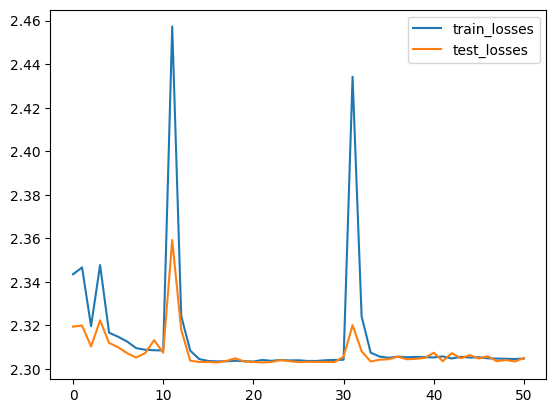

In [ ]:
plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

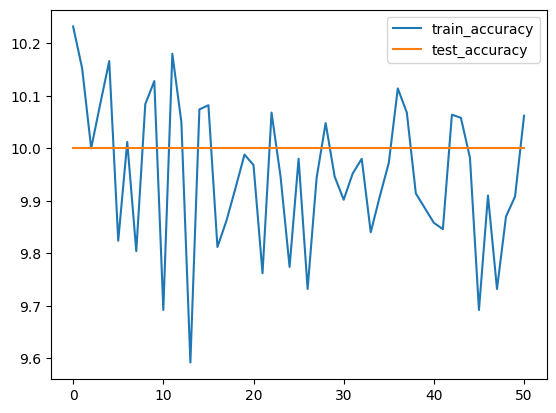

In [ ]:
plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()